# DQN Notebook
In this notebook we investigate how DQN performs on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0/) and [SpaceInvaders-v0](https://gym.openai.com/envs/SpaceInvaders-v0/) environments from [OpenAI Gym library](https://gym.openai.com/).  
The implementation we use is based on [this](https://github.com/keon/deep-q-learning/blob/master/dqn.py). We investigate different models for estimating the Q-value (e.g. a linear model for CartPole, a CNN for SpaceInvaders), with different hyperparameters.

## Imports

In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import gym
import logging
import sys, os, glob, json
print(sys.executable)
import time, datetime
import re
from scipy.signal import savgol_filter


# import local files
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('utils.py'))))
import utils

from dqn.dqn_agent import DQNAgent, QEstimatorsTypes

# set notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



/home/dcodrut/anaconda3/envs/rugenv/bin/python


### Setup

In [4]:
# use notebook backend
%matplotlib notebook

# get the default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# logging setup
# utils.logging_setup_notebook()

# increase plot text size
plt.rcParams.update({'font.size': 12})

---
## Build a model and evaluate the average score of taking random actions
---

### Choose an environment and display its properties

In [ ]:
# env_name, q_estimator_type = 'CartPole-v0', QEstimatorsTypes.MLP
# env_name, q_estimator_type = 'CartPole-v1', QEstimatorsTypes.MLP
env_name, q_estimator_type = 'Breakout-v0', QEstimatorsTypes.CNN
# env_name, q_estimator_type = 'SpaceInvaders-v0', QEstimatorsTypes.CNN

atari_environments = ['SpaceInvaders-v0', 'Breakout-v0']

# inspect environment
env = gym.make(env_name)
print('Environment {} details:'.format(env_name))
print('--- env.action_space.n = {}'.format(env.action_space.n))
print('--- env.observation_space.shape = {}'.format(env.observation_space.shape))
print('--- env.spec.max_episode_seconds = {}'.format(env.spec.max_episode_seconds))
print('--- env.spec.max_episode_steps = {}'.format(env.spec.max_episode_steps))
print('--- env.reward_range = {}'.format(env.reward_range))

if env_name in atari_environments:
    from gym.envs.atari.atari_env import ACTION_MEANING
    print('--- env.env._action_set = {}'.format(env.env._action_set))
    for action in env.env._action_set:
        print('\tAction {} meaning = {}'.format(action, ACTION_MEANING[action]))


### Evaluate RandomAgent

In [ ]:
if env_name in atari_environments:
    num_frames_per_step = 4
    state_size = 84 * 84 * num_frames_per_step
else:
    num_frames_per_step = 1
    state_size = env.observation_space.shape[0]

all_test_scores = []
num_agents = 1
for seed in tqdm(range(num_agents)):
    agent = DQNAgent(state_size=state_size, action_size=env.action_space.n, num_frames_per_step=num_frames_per_step, q_estimator_type=q_estimator_type, seed=seed)
    scores, _ = agent.evaluate(env_name, num_episodes=1, display_delay=0.00, display_frames=False, display_and_save_frames=False, verbose=False, seed=seed)
    all_test_scores.append(scores)
    print(f'seed = {seed}: test scores based on {len(scores)} run(s): {np.mean(scores)} \u00B1 {np.std(scores):.1f}')
print(f'overall: {np.mean(all_test_scores)} \u00B1 {np.std(all_test_scores):.1f}')

---
## Restore one trained model
---

In [5]:
ckpt = './results/peregrine/cartpole_2/env=CartPole-v0_num_runs=10_num_episodes=None_num_iters=10000_ts=2019_01_29---04_02_211211/agent_1548730921.8323517_state_2019_01_29---04_39_episodes_trained_149_iterations_trained_10000_last_ckpt.pk1'

agent = DQNAgent.restore_agent_from_checkpoint(ckpt)

### Play and display/save the frames

In [8]:
# test_env_name = 'SpaceInvaders-v0'
test_env_name = 'CartPole-v0'
# test_env_name = 'CartPole-v1'
# test_env_name = 'Breakout-v0'
scores, frames = agent.evaluate(test_env_name, num_episodes=3, display_delay=0.00, display_frames=True, display_and_save_frames=False, verbose=True,seed=5)
print(f'Test scores based on {len(scores)} run(s): {np.mean(scores)} \u00B1 {np.std(scores):.1f}')

Test scores based on 3 run(s): 200.0 ± 0.0


### Build animation using the frames list from the previous play

In [ ]:
 utils.build_animation(frames, display=True, save_to_file=True, dir_to_save='./results/animations/', filename='{}.mp4'.format(agent.ts))

### Plot agent's test performance

<IPython.core.display.Javascript object>


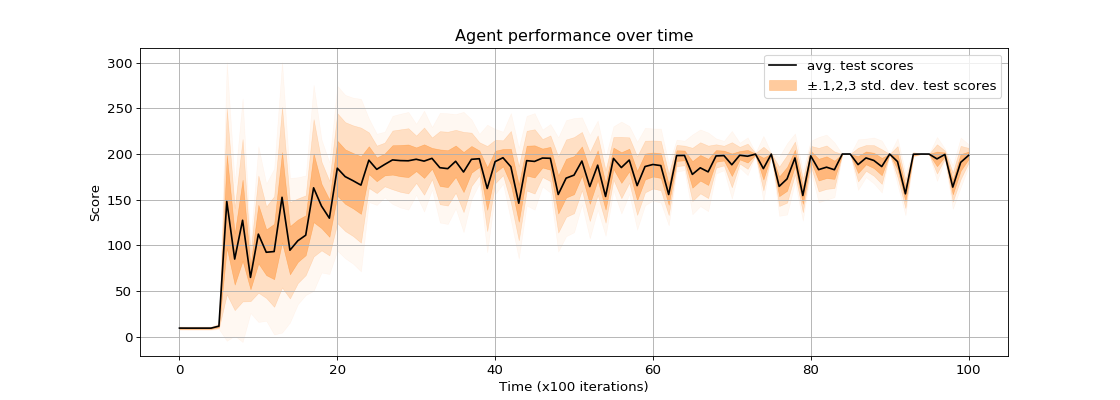

In [9]:
# get the default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# compute the averages and the std. dev.
test_scores_avg = np.array(agent.test_scores).mean(axis=1)
test_scores_std_dev = np.array(agent.test_scores).std(axis=1)

plt.figure(figsize=(14,5))
# plt.plot(agent.training_scores, color=colors[0], label = 'train scores')

# test scores average and +-1,2,3 standard deviations
x = range(len(test_scores_avg))
y = test_scores_avg
plt.plot(x, y, 'k-', label = 'avg. test scores')
std = test_scores_std_dev
plt.fill_between(x, y-std, y+std, alpha=0.4, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5, label='\u00B1.1,2,3 std. dev. test scores')
plt.fill_between(x, y-2*std, y+2*std, alpha=0.2, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5)
plt.fill_between(x, y-3*std, y+3*std, alpha=0.05, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5)

plt.legend()
plt.grid()
plt.title('Agent performance over time')
plt.xlabel(f'Time (x{np.round(agent.num_iters_trained / (len(agent.test_scores) - 1)):.0f} iterations)')
plt.ylabel('Score')
plt.show()

### Plot the exploration rate over time for the previous restored agent

In [4]:
def plot_exploration_over_time(agent):
    plt.figure(figsize=(10, 4))
    x = range(0, agent.num_iters_trained)
    if agent.epsilon_decay_rate == 'linear':
        start = 0
        start_decay = agent.replay_start_size
        stop_decay = agent.final_exploration_step
        stop = agent.num_iters_trained
        
        x = [start, start_decay]
        y = [1.0] * 2 # assuming that initial exploration rate was 1.0
        plt.plot(x, y, '-', color=colors[0], linewidth=2)
        plt.axvline(x=start_decay, linestyle='--', color='k', alpha=0.5)
        plt.text(x=start_decay, y=0.9, s='<--- replay_start_size')
        
        x = np.arange(start_decay, stop_decay)
        y = 1.0 - (x - start_decay) / (stop_decay - start_decay) # assuming that initial exploration rate was 1.0
        plt.plot(x, y, ':k', linewidth=1.0)
        y = np.maximum(y, agent.epsilon_min) # epsilon is linearly annealed until it reaches the minimum value
        plt.plot(x, y, '-', color=colors[0], linewidth=2) 
        plt.axvline(x=stop_decay, linestyle='--', color='k', alpha=0.5)
        plt.text(x=stop_decay, y=0.8, s='<--- final_exploration_step')
        
        x = [stop_decay, stop]
        y = [agent.epsilon_min] * 2
        plt.plot(x, y, '-', color=colors[0], linewidth=2)
        plt.text(x=stop_decay + (stop - stop_decay) / 1.5, y=agent.epsilon_min, va='bottom', s='<--- epsilon_min', rotation=90)
        
    plt.grid()
    plt.yticks(np.arange(0,1.01,0.1))
    plt.ylim(bottom=0.0)
    plt.xlabel('Time (as number of iterations)')
    plt.ylabel('Epsilon = exploration rate')
    plt.title('Exploration rate schedule')
    plt.show()


<IPython.core.display.Javascript object>


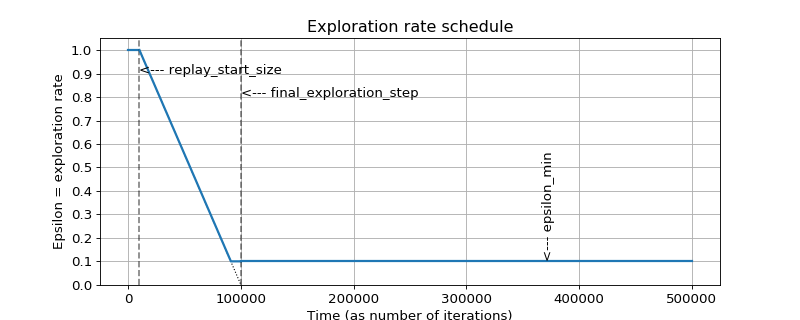

In [30]:
plot_exploration_over_time(agent)

### Check the execution time using the logs

In [ ]:
# read the log file
# fn = './peregrine_jobs/slurm/slurm-4029562.out'
fn = './peregrine_jobs/slurm/slurm-4089153.out'

with open(fn, 'r') as f:
    txt = f.readlines()

# gather the execution times of each episode
list_num_iters = []
list_ts = []
for line in txt:
    if 'finished' in line:
        i = line.find("after ") + 6
        j = line.find("/", i)
        num_iters_last_episode = int(line[i:j])
        list_num_iters.append(num_iters_last_episode)
        ts_str = line[1:19]
        ts = datetime.datetime.strptime('2019/'+ts_str, "%Y/%m/%d-%H:%M:%S.%f").replace(tzinfo=datetime.timezone.utc).timestamp()
        list_ts.append(ts)

# using the execution times of each episode and the number of iterations, compute the execution time per iteration
list_time_per_iter = []
for i in range(1, len(list_ts)):
    list_time_per_iter.append((list_ts[i] - list_ts[i-1]) / list_num_iters[i])
    
print(f'Average time = {np.mean(list_time_per_iter):.3f} \u00B1 {np.std(list_time_per_iter):.3f} (s/iter) ===> ~{1/np.mean(list_time_per_iter):.1f} iter/s')

plt.figure(figsize=(16, 5))
plt.plot(list_time_per_iter)
plt.grid()
plt.title('Average time per iteration for each episode')
plt.xlabel('Episode')
plt.ylabel('Average time per iteration (s)')
plt.show()

#### (For space-invaders): Display random frames from agent's memory
A state is defined as a stacked sequence of num_frames_per_step consecutive frames.  
For running the following section the agent should have been saved including his memory (usually the memory is not included in the agent checkpoint because it takes to much disk space).

<IPython.core.display.Javascript object>


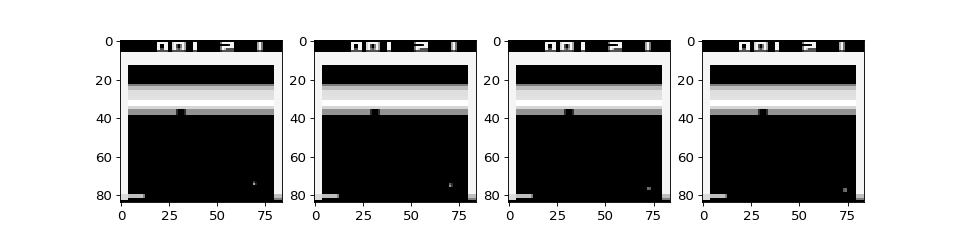

In [24]:
k = np.random.randint(0, min(agent.memory_size, agent.num_iters_trained), 1)[0]
mem = agent.memory[0][k].reshape((84, 84, agent.num_frames_per_step))
plt.figure(figsize=(12, 3))
for i in range(agent.num_frames_per_step):
    plt.subplot(1,agent.num_frames_per_step,i+1)
    plt.imshow(mem[:,:,i], cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


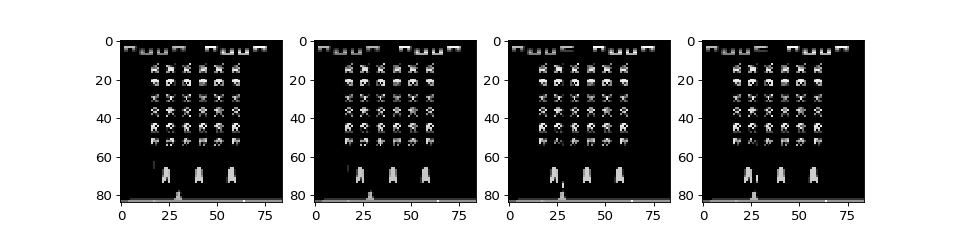

---
## Restore multiple agents (i.e. trained with different seeds) and analyze the errors on average
---

In [ ]:
dirs = [d for d in glob.glob('./results/peregrine/cartpole_2/*') if os.path.isdir(d)]
dirs.sort(key=os.path.getmtime)

for d in dirs:
    print(f"experiment_dir = '{d}'")

all_avg_test_scores_all_agents = []
all_std_test_scores_all_agents = []
all_fn = []

for jd, d in enumerate(tqdm(dirs)):
    experiment_dir = d
    print(f'\n\n\nExperiment directory {jd + 1}/{len(dirs)}: {experiment_dir}')
    
    # read the settings
    settings_file = glob.glob('{}/settings*'.format(experiment_dir))[0]
    with open(settings_file, 'r') as fp:
        settings = json.load(fp)

    print(f'Settings - {settings_file}')
    for k in settings.keys():
        print(f'\t{k}: {settings[k]}')

    # read the hyper-parameters
    hps_file = glob.glob('{}/hps*'.format(experiment_dir))[0]
    with open(hps_file, 'r') as fp:
        hps = json.load(fp)

    print(f'\nHyperparameters - {hps_file}')
    for k in hps.keys():
        print(f'\t{k}: {hps[k]}')

    # read the latest checkpoint files of each agent
    last_ckpts = glob.glob('{}/*last_ckpt.pk1'.format(experiment_dir))
    
    # if there is no the latest checkpoint (probably because the job failed), try to read the last existing checkpoint.
    if len(last_ckpts) == 0: 
        print(f"{experiment_dir} doesn't have a last_ckpt file. Trying to use the last checkpoint.")
        temp = glob.glob('{}/*.pk1'.format(experiment_dir))
        if len(temp) == 0:
            print('No checkpoints found. Continue.')
            continue
        temp.sort(key=os.path.getmtime)
        last_ckpts = [temp[-1]]
        
    print(f'The following checkpoint will be used:\n\t {last_ckpts[0]}')

    try:
        for x in restored_agents:
            del x
        del restored_agents
    except: 
        pass

    restored_agents = []
    for i, last_ckpt in enumerate(tqdm(last_ckpts)):
        agent = DQNAgent.restore_agent_from_checkpoint(last_ckpt)
        if i == 0:
            print(f'Agent {i+1}/{len(last_ckpts)} summary: \n')
            print(agent.summary)
        restored_agents.append(agent)
        
#     plot_exploration_over_time(restored_agents[0])
        
    avg_test_scores_all_agents=[]
    std_test_scores_all_agents=[]
    for agent in restored_agents:
        a = np.array(agent.test_scores)
        avg_test_scores_all_agents.append(np.mean(np.array(agent.test_scores), axis=1))
        std_test_scores_all_agents.append(np.std(np.array(agent.test_scores), axis=1))
    
    all_avg_test_scores_all_agents.append(avg_test_scores_all_agents)
    std_test_scores_all_agents.append(std_test_scores_all_agents)
    
    plt.figure(figsize=(15, 5))
    for i in range(len(restored_agents)):
        if len(restored_agents) == 1:
            plt.plot(avg_test_scores_all_agents[i], '-k', label=f'avg ({restored_agents[i].ts})')
        else:
            plt.plot(avg_test_scores_all_agents[i], label=f'avg ({restored_agents[i].ts})')
#         print(restored_agents[i].ts)
        
    # if we have just one agent plot its test scores standard deviation
    if len(restored_agents)==1:
        avg = avg_test_scores_all_agents[0]
        std = std_test_scores_all_agents[0]
        x = range(len(std))
        plt.fill_between(x, avg-std, avg+std, alpha=0.4, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5, label='\u00B11 std. dev.')

    plt.legend()
    plt.title('Agent performance over time')
    plt.xlabel(f'Time (x {settings["test_freq"]} iterations)')
    plt.ylabel('Score')
    plt.grid()
    plt.show()
    fn = f'{os.path.split(experiment_dir)[-1]}_agents_avg_test_scores_tn_{hps["use_target_network"]}_dn_{hps["use_double_network"]}_q-model_{hps["q_estimator_type"]}'
    plt.savefig(f'./results/graphs/last/{fn}.png')
    plt.savefig(f'{d}/{fn}.png')
    
    all_fn.append(fn)
    
    # if there are multiple agents, print the overall average performance and the standard deviation
    if len(restored_agents)>1:
       
        plt.figure(figsize=(12, 4))
        avg = np.array(avg_test_scores_all_agents).mean(axis=0)
        std = np.array(avg_test_scores_all_agents).std(axis=0)

        # test scores average and +-1,2,3 standard deviations
        x = range(len(avg))
        plt.plot(x, avg, 'k-', label = 'avg. test scores')
        plt.fill_between(x, avg-std, avg+std, alpha=0.4, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5, label='\u00B11 std. dev. test scores')
        # plt.fill_between(x, avg-2*std, avg+2*std, alpha=0.2, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5)
        # plt.fill_between(x, avg-3*std, avg+3*std, alpha=0.05, edgecolor=colors[1], facecolor=colors[1], linewidth=0.5)

        plt.legend()
        plt.grid()
        plt.title('Agent performance over time')
        plt.xlabel(f'Time (x {settings["test_freq"]} iterations)')
        plt.ylabel('Score')
        plt.title('Average performance over all {} runs with different seeds'.format(len(restored_agents)))
        plt.show()
        fn = f'{os.path.split(experiment_dir)[-1]}_agents_global_avg_test_scores_and_1std_tn_{hps["use_target_network"]}_dn_{hps["use_double_network"]}_q-model_{hps["q_estimator_type"]}'
        plt.savefig(f'./results/graphs/{fn}.png')
        plt.savefig(f'{d}/{fn}.png')

#     if hps['env_name'] == 'CartPole-v0': # evaluate on CartPole-v1 (which has the maximum number of steps 500 instead of 200)
#         all_avg_scores = []
#         for agent in restored_agents:
#             test_env_name = 'CartPole-v1'
#             scores, frames = agent.evaluate(test_env_name, num_episodes=25, display_delay=0.00, display_frames=False, display_and_save_frames=False, verbose=True,seed=0)
#             print(f'Test scores based on {len(scores)} run(s): {np.mean(scores)} \u00B1 {np.std(scores):.1f}')
#             all_avg_scores.append(np.mean(scores))
            
#     print(pd.Series(all_avg_scores).describe())

#### Plot the averages of the test scores for each agent

In [ ]:
plt.figure(figsize=(12, 4))

reordering = []

smooth = True

for k, experiment_dir in enumerate(dirs):
    # read the hyper-parameters
    hps_file = glob.glob('{}/hps*'.format(experiment_dir))[0]
    with open(hps_file, 'r') as fp:
        hps = json.load(fp)
        
    use_tn = hps['use_target_network']
    use_dql = hps['use_double_network']
    use_dn = (hps['q_estimator_type'] == QEstimatorsTypes.DUELING_MLP) or (hps['q_estimator_type'] == QEstimatorsTypes.DUELING_CNN)
    
    _label = f'{"+" if use_tn else "-"}tn, {"+" if use_dql else "-"}dql, {"+" if use_dn else "-"}dn'
    
    avg_all_agents_with_current_hps = np.array(all_avg_test_scores_all_agents[k]).mean(axis=0)
    
    # smooth the averages
    if smooth:
        avg_all_agents_with_current_hps = savgol_filter(avg_all_agents_with_current_hps, 7, 2)
    
    if not use_tn and not use_dql and not use_dn:
        ic = 0
    elif use_tn and not use_dql and not use_dn:
        ic = 1
    elif use_tn and use_dql and not use_dn:
        ic = 2
    elif use_tn and not use_dql and use_dn:
        ic = 3
    elif use_tn and use_dql and use_dn:
        ic = 4
    reordering.append(ic)
    plt.plot(avg_all_agents_with_current_hps,color=colors[ic], label=_label)
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
order = [np.where(np.array(reordering) == i)[0][0] for i in range(len(dirs))]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title('Comparison between improvements')
plt.xlabel(f'Time (x{np.round(restored_agents[0].num_iters_trained / (len(restored_agents[0].test_scores) - 1)):.0f} iterations)')
plt.ylabel('Score')
plt.savefig(f'{os.path.split(experiment_dir)[0]}/comparison_{"smoothed" if smooth else ""}.png')
plt.show()
